### Univariate, multistep forecast using LSTM 

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from math import sqrt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from keras import metrics

data = pd.read_csv('/Users/alket/Desktop/dati/new_data_backfill_forwfill.csv',index_col = 0)

agg_by_cell = data.groupby(by = ['cell_num'])
one_cell = agg_by_cell.get_group('495-1266')
series = one_cell['nr_people'].values
print(type(series))

/Users/alket/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<class 'numpy.ndarray'>


### Prepare input data for LSTM model

In [62]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
         # find the end of this pattern
         end_ix = i + n_steps_in
         out_end_ix = end_ix + n_steps_out
         # check if we are beyond the sequence
         if out_end_ix > len(sequence):
             break
         # gather input and output parts of the pattern
         seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
         X.append(seq_x)
         y.append(seq_y)
    return np.array(X), np.array(y)

# choose a number of time steps
n_steps_in, n_steps_out = 20, 20

# split into samples
X, y = split_sequence(series, n_steps_in, n_steps_out)
count = 0
for i in range(len(X)):
    print(X[i], y[i])
    count +=1
    if count>1: break

[326. 330. 321. 320. 318. 318. 321. 317. 318. 318. 316. 312. 312. 312.
 309. 306. 304. 306. 307. 308.] [309. 310. 315. 312. 312. 309. 306. 310. 305. 307. 308. 308. 308. 308.
 308. 317. 319. 319. 319. 339.]
[330. 321. 320. 318. 318. 321. 317. 318. 318. 316. 312. 312. 312. 309.
 306. 304. 306. 307. 308. 309.] [310. 315. 312. 312. 309. 306. 310. 305. 307. 308. 308. 308. 308. 308.
 317. 319. 319. 319. 339. 328.]


In [63]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

### Prepare train - test set

In [66]:
train_size = 8000

train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y= y[:train_size], y[train_size:]
print(train_X.shape, test_X.shape)

(8000, 20, 1) (3769, 20, 1)


### LSTM Model

In [65]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in,n_features)))
model.add(LSTM(100, activation='relu')) 
model.add(Dense(n_steps_out)) 
model.compile(optimizer='adam', loss='mse', metrics=[metrics.mae, 'accuracy'])

# fit model
model.fit(train_X, train_y, epochs=50, verbose=2)

Epoch 1/50
 - 9s - loss: 17146.3889 - mean_absolute_error: 64.5240 - accuracy: 0.0559
Epoch 2/50
 - 8s - loss: 501.5916 - mean_absolute_error: 17.5343 - accuracy: 0.0515
Epoch 3/50
 - 9s - loss: 444.8554 - mean_absolute_error: 16.5262 - accuracy: 0.0566
Epoch 4/50
 - 8s - loss: 403.0679 - mean_absolute_error: 15.6925 - accuracy: 0.0584
Epoch 5/50
 - 8s - loss: 406.3564 - mean_absolute_error: 15.7385 - accuracy: 0.0709
Epoch 6/50
 - 9s - loss: 380.4845 - mean_absolute_error: 15.2220 - accuracy: 0.0742
Epoch 7/50
 - 9s - loss: 359.0600 - mean_absolute_error: 14.8057 - accuracy: 0.0763
Epoch 8/50
 - 9s - loss: 350.4734 - mean_absolute_error: 14.5995 - accuracy: 0.0799
Epoch 9/50
 - 9s - loss: 343.7890 - mean_absolute_error: 14.4341 - accuracy: 0.0793
Epoch 10/50
 - 9s - loss: 374.0683 - mean_absolute_error: 15.1463 - accuracy: 0.0751
Epoch 11/50
 - 9s - loss: 356.8091 - mean_absolute_error: 14.7468 - accuracy: 0.0719
Epoch 12/50
 - 9s - loss: 338.5407 - mean_absolute_error: 14.3306 - accu

### Computer forcasting error.

Mean Absolute Error =  3.3505381996239625


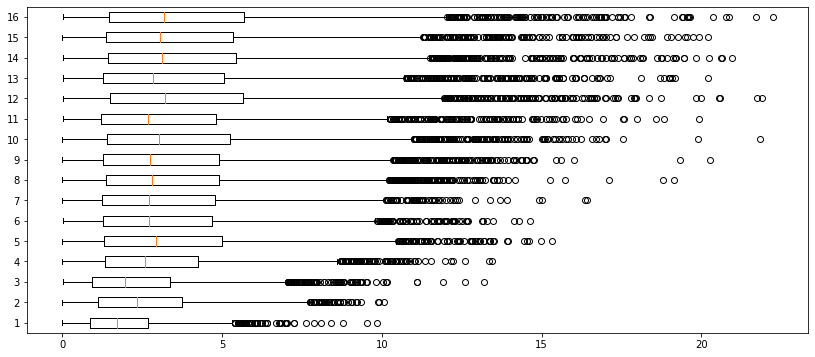

In [45]:
# predict and compute error
predicted = np.array([])

for i in range(len(test_X)):
    # x_input = X[i].reshape((1, n_steps))
    x_input = test_X[i].reshape((1, n_steps_in, n_features))
    yhat = model.predict(x_input, verbose=0)
    #print(yhat)
    predicted = np.append(predicted, yhat) 


expected = test_y
# abs difference

predicted2 = predicted.reshape(expected.shape[0], expected.shape[1])
difference = abs((expected - predicted2))

print('Mean Absolute Error = ', np.mean(difference))
# show boxplot
plt.figure(figsize = (14,6))
plt.boxplot(difference, vert= False);
plt.show()

### Distribution of cumulative MAE 

60432


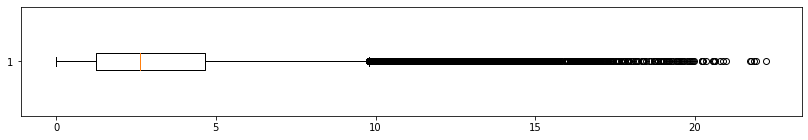

In [67]:
new_s = int(difference.shape[1]) * int(difference.shape[0]) 
print(new_s)
d = np.reshape(difference, new_s)
# show boxplot
plt.figure(figsize = (14,2))
plt.boxplot(d, vert= False);
plt.show()